In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [0]:
from sklearn.model_selection import train_test_split


class Stacker:

    def __init__(self, blender_model, subset_proportion=0.5):
        self.blender_model = blender_model
        self.layers = None
        self._subset_proportion = subset_proportion

    def add_layer(self, models: list):
        if self.layers is None:
            self.layers = [models]
        else:
            self.layers.append(models)

    def fit_layer(self, layer_no, X, y):
        X_train, X_learn, y_train, y_learn = train_test_split(X, y, test_size=self._subset_proportion)

        rows = []
        for model in self.layers[layer_no]:
            model.fit(X_train, y_train)
            row = model.predict(X_learn)
            rows.append(row.reshape(-1, 1))
        X_new = np.hstack(rows)

        return X_new, y_learn

    def fit(self, X, y):
        for layer in range(len(self.layers)):
            X, y = self.fit_layer(layer, X, y)
        self.blender_model.fit(X, y)

    def predict_layer(self, layer_no, X):
        rows = []
        for model in self.layers[layer_no]:
            row = model.predict(X)
            rows.append(row.reshape(-1, 1))
        X_new = np.hstack(rows)

        return X_new
            
    def predict(self, X):
        rows = []
        for level in range(len(self.layers)):
            X = self.predict_layer(level, X)

        return self.blender_model.predict(X)

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=250, noise=0.25, random_state=42)

stack_clf = Stacker(DecisionTreeClassifier())
stack_clf.add_layer([KNeighborsClassifier(), SVC(), LogisticRegression()])
stack_clf.add_layer([KNeighborsClassifier(), DecisionTreeClassifier()])
stack_clf.fit(X, y)
stack_clf.predict(np.array([1, 1]).reshape(1, -1))

print(accuracy_score(y, stack_clf.predict(X)))

0.932


In [0]:
from matplotlib.colors import ListedColormap


def draw_clf(model, X, y, meshgrid_steps=100, meshgrid_padding=0.05, fig_size=(6, 6), c_lightering=0.3, 
             feature_names=None, target_names=None, title=None, raw_data=False):

    x0_min, x0_max = np.min(X[:, 0]), np.max(X[:, 0])
    x1_min, x1_max = np.min(X[:, 1]), np.max(X[:, 1])

    x0_delta = (x0_max - x0_min) * meshgrid_padding
    x1_delta = (x1_max - x1_min) * meshgrid_padding

    x0_values = np.linspace(x0_min - x0_delta, x0_max + x0_delta, meshgrid_steps);
    x1_values = np.linspace(x1_min - x1_delta, x1_max + x1_delta, meshgrid_steps);

    xx0, xx1 = np.meshgrid(x0_values, x1_values)
    z = model.predict(np.c_[xx0.ravel(), xx1.ravel()])
    z = z.reshape(xx0.shape)

    current_palette = np.array(sns.color_palette()[:len(np.unique(y))])
    lighter_pallete = ListedColormap(current_palette + (1 - current_palette) * c_lightering)

    if raw_data:
        return xx0, xx1, z, lighter_pallete

    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    
    ax.pcolormesh(xx0, xx1, z, cmap=lighter_pallete)

    labels = [f'class {x} - {target_names[x]}' if isinstance(target_names, (np.ndarray, list)) else f'class {x}' 
              for x in range(len(np.unique(y)))]

    for idx, lbl in enumerate(labels):
        ax.scatter(X[np.where(y==idx), 0], X[np.where(y==idx), 1], label=lbl, ec='w')
        ax.legend()

    ax.set_xlabel(feature_names[0] if feature_names else 'x0')
    ax.set_ylabel(feature_names[1] if feature_names else 'x1')
    
    if title:
        ax.set_title(title)

    return fig, ax

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


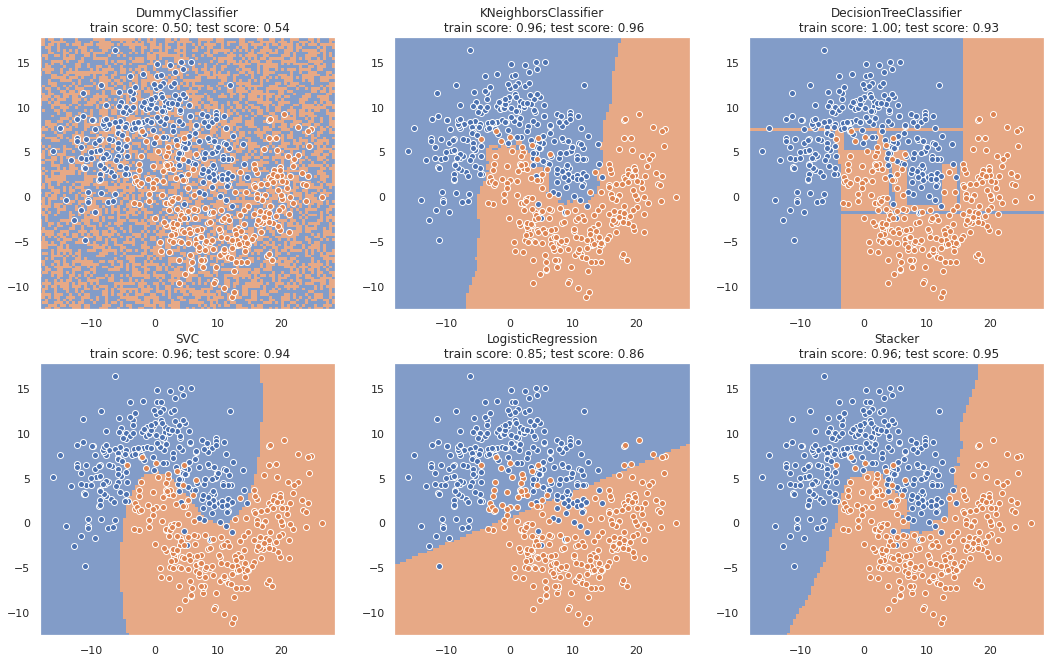

In [143]:
from sklearn.dummy import DummyClassifier

X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X *= 10

dummy = DummyClassifier()
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier()
svc = SVC()
log_reg = LogisticRegression()

stack = Stacker(DecisionTreeClassifier())
stack.add_layer([KNeighborsClassifier(), DecisionTreeClassifier()])
stack.add_layer([SVC(), KNeighborsClassifier()])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 11))

for model, ax in zip([dummy, knn, tree, svc, log_reg, stack], [ax for subaxes in axes for ax in subaxes]):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model.fit(X_train, y_train)
    score_train = accuracy_score(y_train, model.predict(X_train))
    score_test = accuracy_score(y_test, model.predict(X_test))

    xx0, xx1, z, pallete = draw_clf(model, X, y, raw_data=True)

    ax.pcolormesh(xx0, xx1, z, cmap=pallete)
    ax.scatter(X[np.where(y==0), 0], X[np.where(y==0), 1], ec='w')
    ax.scatter(X[np.where(y==1), 0], X[np.where(y==1), 1], ec='w')
    ax.set_title(f'{model.__class__.__name__}\n train score: {score_train:.2f}; test score: {score_test:.2f}')
